###<br>All dataframe libraries come with a grammar of data manipulation, a set of verbs to solve the most common data manipulation tasks.

##### In PySpark some of the most fundamental are:
    
- **withColumn()** adds new variables that are functions of existing variables
- **select()** picks variables based on their names.
- **filter()** picks cases based on their values.
- **agg()** reduces multiple values down to a single summary.
- **orderBy()** changes the order of the rows

###These all combine naturally with groupBy() which allows you to perform any operation “by group”.

###### The above is a merciless reworking/theft of how dplyr talks about their grammar of data manipulation 🥷
###### 👉 [https://dplyr.tidyverse.org/index.html](https://dplyr.tidyverse.org/index.html)
###### For help with specific functions, the PySpark docs are better than an LLM
###### 👉 [https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.agg.html](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.agg.html)

### <br>Let's start by loading in our data, then checking out how filter works.

In [0]:
salesurl='https://raw.githubusercontent.com/Twin-Cities-Data/Datasets/refs/heads/main/Property_Sales_2019_to_2023.csv'
import pandas as pd
dfSales=pd.read_csv(salesurl)
#A little cleaning first before we turn our df into a spark df
dfSales['PIN']=dfSales['PIN'].str.replace('-','')
dfSales=dfSales[['PIN','SALE_DATE','COMMUNITY_DESC','NBHD_DESC','PROPTYPE_DESC','GROSS_SALE_PRICE','DOWNPAYMENT']].\
    dropna(subset='GROSS_SALE_PRICE').\
    fillna(0).\
    query('GROSS_SALE_PRICE>0')
# Turn pandas DF to spark DF
dfSales = spark.createDataFrame(dfSales)

url='https://raw.githubusercontent.com/Twin-Cities-Data/Datasets/refs/heads/main/Assessing_Department_Parcel_Data_2024_Trim.csv'
df=pd.read_csv(url)
df=df.drop_duplicates(['X','Y']).reset_index()
df['PIN']=df['PIN'].str.replace('p','')
df=spark.createDataFrame(df)


/home/spark-7dfbf7b7-eea7-40b6-97ca-5a/.ipykernel/70076/command-3219381555098183-890070234:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dfSales=pd.read_csv(salesurl)
No such comm: LSP_COMM_ID


#### <br>Our first set of verbs are special functions call "methods", methods belong to objects.
#### To call a method, we use the dot notation, object.method(arguments)
#### Ex: df.filter(something)

#### <br>"filter" itself works just like "where" in SQL, condition on a column name and execute to restrict the dataframe to only those rows that meet the condition.

In [0]:
dfSales.filter('GROSS_SALE_PRICE>=100000').show()

+-------------+--------------------+--------------+-------------+--------------------+----------------+-----------+
|          PIN|           SALE_DATE|COMMUNITY_DESC|    NBHD_DESC|       PROPTYPE_DESC|GROSS_SALE_PRICE|DOWNPAYMENT|
+-------------+--------------------+--------------+-------------+--------------------+----------------+-----------+
|1402824140053|2019/01/09 06:00:...|       NOKOMIS|         HALE|         RESIDENTIAL|        250000.0|        0.0|
|2302924320357|2019/01/09 06:00:...|      DOWNTOWN|DOWNTOWN WEST|         CONDOMINIUM|        222000.0|    64964.0|
|0302824210311|2019/01/09 06:00:...|    POWDERHORN|      LYNDALE|         CONDOMINIUM|        127500.0|        0.0|
|0302824210294|2019/01/09 06:00:...|    POWDERHORN|      LYNDALE|         CONDOMINIUM|        127500.0|        0.0|
|0302824210167|2019/01/09 06:00:...|    POWDERHORN|      LYNDALE|         CONDOMINIUM|        127500.0|        0.0|
|0302824210274|2019/01/09 06:00:...|    POWDERHORN|      LYNDALE|    CON

####<br>Note how we chained .show(), which is a light weight method to display our data
###### You will see more chaining as we progress

### Multiple conditions can go in filter

In [0]:
dfSales.filter('COMMUNITY_DESC=="NOKOMIS" AND GROSS_SALE_PRICE>=100000').show()

+-------------+--------------------+--------------+------------+------------------+----------------+-----------+
|          PIN|           SALE_DATE|COMMUNITY_DESC|   NBHD_DESC|     PROPTYPE_DESC|GROSS_SALE_PRICE|DOWNPAYMENT|
+-------------+--------------------+--------------+------------+------------------+----------------+-----------+
|1402824140053|2019/01/09 06:00:...|       NOKOMIS|        HALE|       RESIDENTIAL|        250000.0|        0.0|
|2402824130056|2019/01/10 06:00:...|       NOKOMIS|     WENONAH|       RESIDENTIAL|        239900.0|        0.0|
|2402824130079|2019/01/15 06:00:...|       NOKOMIS|     WENONAH|       RESIDENTIAL|        132500.0|     3975.0|
|1902823140019|2019/01/15 06:00:...|       NOKOMIS| MORRIS PARK|       RESIDENTIAL|        174000.0|     5220.0|
|1802823240119|2019/01/16 06:00:...|       NOKOMIS|   MINNEHAHA|        COMMERCIAL|        260000.0|    52000.0|
|1402824120158|2019/01/11 06:00:...|       NOKOMIS|    NORTHROP|       RESIDENTIAL|        26150

## Filter is so much like where that is also where

In [0]:
dfSales.where('(COMMUNITY_DESC=="NOKOMIS" AND GROSS_SALE_PRICE>=100000) OR DOWNPAYMENT==0').show()

+-------------+--------------------+--------------+---------------+------------------+----------------+-----------+
|          PIN|           SALE_DATE|COMMUNITY_DESC|      NBHD_DESC|     PROPTYPE_DESC|GROSS_SALE_PRICE|DOWNPAYMENT|
+-------------+--------------------+--------------+---------------+------------------+----------------+-----------+
|1402824140053|2019/01/09 06:00:...|       NOKOMIS|           HALE|       RESIDENTIAL|        250000.0|        0.0|
|0302824210311|2019/01/09 06:00:...|    POWDERHORN|        LYNDALE|       CONDOMINIUM|        127500.0|        0.0|
|0302824210294|2019/01/09 06:00:...|    POWDERHORN|        LYNDALE|       CONDOMINIUM|        127500.0|        0.0|
|0302824210167|2019/01/09 06:00:...|    POWDERHORN|        LYNDALE|       CONDOMINIUM|        127500.0|        0.0|
|0302824210274|2019/01/09 06:00:...|    POWDERHORN|        LYNDALE|  CONDO - GAR/MISC|        127500.0|        0.0|
|1211821230283|2019/01/10 06:00:...|        CAMDEN|   LIND-BOHANON|     

In [0]:
#### orderBy is just like order by in SQL  

In [0]:
dfSales.orderBy('GROSS_SALE_PRICE',ascending=False).show()

+-------------+--------------------+--------------+-------------+-------------+----------------+-----------+
|          PIN|           SALE_DATE|COMMUNITY_DESC|    NBHD_DESC|PROPTYPE_DESC|GROSS_SALE_PRICE|DOWNPAYMENT|
+-------------+--------------------+--------------+-------------+-------------+----------------+-----------+
|2702924110012|2019/04/01 05:00:...|      DOWNTOWN|DOWNTOWN WEST|   COMMERCIAL|         3.136E8|     7.84E7|
|2202924410260|2023/07/19 05:00:...|      DOWNTOWN|DOWNTOWN WEST|   COMMERCIAL|          2.25E8|        0.0|
|2202924410286|2023/07/19 05:00:...|      DOWNTOWN|DOWNTOWN WEST|   COMMERCIAL|          2.25E8|        0.0|
|2202924410245|2023/07/19 05:00:...|      DOWNTOWN|DOWNTOWN WEST|   COMMERCIAL|          2.25E8|        0.0|
|2202924410242|2023/07/19 05:00:...|      DOWNTOWN|DOWNTOWN WEST|   COMMERCIAL|          2.25E8|        0.0|
|2202924410261|2023/07/19 05:00:...|      DOWNTOWN|DOWNTOWN WEST|   COMMERCIAL|          2.25E8|        0.0|
|2202924410235|2023

### Another helpful verb to chain in with orderBy is "limit"
### This gives us the biggest sale in our data

In [0]:
dfSales.orderBy('GROSS_SALE_PRICE',ascending=False).limit(1).show()

+-------------+--------------------+--------------+-------------+-------------+----------------+-----------+
|          PIN|           SALE_DATE|COMMUNITY_DESC|    NBHD_DESC|PROPTYPE_DESC|GROSS_SALE_PRICE|DOWNPAYMENT|
+-------------+--------------------+--------------+-------------+-------------+----------------+-----------+
|2702924110012|2019/04/01 05:00:...|      DOWNTOWN|DOWNTOWN WEST|   COMMERCIAL|         3.136E8|     7.84E7|
+-------------+--------------------+--------------+-------------+-------------+----------------+-----------+



#### <br> Considering what we have learned, how can we get the smallest sale in Nokomis?
###### Tell me and I'll try it

##<br> Another verb from SQL that you should know is select
## Select contrains the columns we get back

In [0]:
dfSales.select("COMMUNITY_DESC","DOWNPAYMENT").limit(5).show()

+--------------+-----------+
|COMMUNITY_DESC|DOWNPAYMENT|
+--------------+-----------+
|       NOKOMIS|        0.0|
|      DOWNTOWN|    64964.0|
|    POWDERHORN|        0.0|
|    POWDERHORN|        0.0|
|    POWDERHORN|        0.0|
+--------------+-----------+



#### We can also rename columns in our select statement

In [0]:
dfSales.select(dfSales.COMMUNITY_DESC.alias("COM"),"DOWNPAYMENT").limit(5).show()

+----------+-----------+
|       COM|DOWNPAYMENT|
+----------+-----------+
|   NOKOMIS|        0.0|
|  DOWNTOWN|    64964.0|
|POWDERHORN|        0.0|
|POWDERHORN|        0.0|
|POWDERHORN|        0.0|
+----------+-----------+



### There are many helper function in PySpark

In [0]:
import pyspark.sql.functions as F
dfSales.select(F.col("COMMUNITY_DESC"),F.col("DOWNPAYMENT")).limit(5).show()


+--------------+-----------+
|COMMUNITY_DESC|DOWNPAYMENT|
+--------------+-----------+
|       NOKOMIS|        0.0|
|      DOWNTOWN|    64964.0|
|    POWDERHORN|        0.0|
|    POWDERHORN|        0.0|
|    POWDERHORN|        0.0|
+--------------+-----------+



In [0]:
import pyspark.sql.functions as F
dfSales.select(
    F.col("COMMUNITY_DESC").alias("COM"),
    F.col("DOWNPAYMENT")
    ).\
    limit(5).\
    show()


+----------+-----------+
|       COM|DOWNPAYMENT|
+----------+-----------+
|   NOKOMIS|        0.0|
|  DOWNTOWN|    64964.0|
|POWDERHORN|        0.0|
|POWDERHORN|        0.0|
|POWDERHORN|        0.0|
+----------+-----------+



#### In SQL we create new columns in the select statement. <br >In pandas and we use assign, "withColumn" is very similar. 
 

In [0]:
dfSales.withColumn("PercentDown",dfSales.DOWNPAYMENT/dfSales.GROSS_SALE_PRICE).limit(5).display()

PIN SALE_DATE COMMUNITY_DESC NBHD_DESC PROPTYPE_DESC GROSS_SALE_PRICE DOWNPAYMENT PercentDown 1402824140053 2019/01/09 06:00:00+00 NOKOMIS HALE RESIDENTIAL 250000.0 0.0 0.0 2302924320357 2019/01/09 06:00:00+00 DOWNTOWN DOWNTOWN WEST CONDOMINIUM 222000.0 64964.0 0.2926306306306306 0302824210311 2019/01/09 06:00:00+00 POWDERHORN LYNDALE CONDOMINIUM 127500.0 0.0 0.0 0302824210294 2019/01/09 06:00:00+00 POWDERHORN LYNDALE CONDOMINIUM 127500.0 0.0 0.0 0302824210167 2019/01/09 06:00:00+00 POWDERHORN LYNDALE CONDOMINIUM 127500.0 0.0 0.0

#### We can also create columns in our select satement

In [0]:
dfSales.\
    select(
        "COMMUNITY_DESC",
        "DOWNPAYMENT",
        (F.col('DOWNPAYMENT')/F.col('GROSS_SALE_PRICE')).alias("PercentDown")
        ).\
    limit(5).\
    show()


+--------------+-----------+------------------+
|COMMUNITY_DESC|DOWNPAYMENT|       PercentDown|
+--------------+-----------+------------------+
|       NOKOMIS|        0.0|               0.0|
|      DOWNTOWN|    64964.0|0.2926306306306306|
|    POWDERHORN|        0.0|               0.0|
|    POWDERHORN|        0.0|               0.0|
|    POWDERHORN|        0.0|               0.0|
+--------------+-----------+------------------+



##<br>To keep product of our code for later use, we need to save it

In [0]:
dfSales=dfSales.withColumn("PercentDown",dfSales.DOWNPAYMENT/dfSales.GROSS_SALE_PRICE)

In [0]:
dfSales.limit(5).display()

PIN SALE_DATE COMMUNITY_DESC NBHD_DESC PROPTYPE_DESC GROSS_SALE_PRICE DOWNPAYMENT PercentDown 1402824140053 2019/01/09 06:00:00+00 NOKOMIS HALE RESIDENTIAL 250000.0 0.0 0.0 2302924320357 2019/01/09 06:00:00+00 DOWNTOWN DOWNTOWN WEST CONDOMINIUM 222000.0 64964.0 0.2926306306306306 0302824210311 2019/01/09 06:00:00+00 POWDERHORN LYNDALE CONDOMINIUM 127500.0 0.0 0.0 0302824210294 2019/01/09 06:00:00+00 POWDERHORN LYNDALE CONDOMINIUM 127500.0 0.0 0.0 0302824210167 2019/01/09 06:00:00+00 POWDERHORN LYNDALE CONDOMINIUM 127500.0 0.0 0.0

#<br>The agg method is just like agg in pandas
#<br>


#<br> You can agg using dictionary syntax

In [0]:

dfSales.agg({"GROSS_SALE_PRICE":"mean"}).show()

+----------------------+
|mean(GROSS_SALE_PRICE)|
+----------------------+
|     878290.6909747293|
+----------------------+



# Column syntax is better

In [0]:
dfSales.\
    agg(
        F.min(dfSales.GROSS_SALE_PRICE).alias("MinGrossSalePrice"),
        F.mean(dfSales.GROSS_SALE_PRICE).alias("MeanGrossSalePrice"),
        F.max(dfSales.GROSS_SALE_PRICE).alias("MaxGrossSalePrice"),
        ).\
    show()

+-----------------+------------------+-----------------+
|MinGrossSalePrice|MeanGrossSalePrice|MaxGrossSalePrice|
+-----------------+------------------+-----------------+
|              1.0| 878290.6909747293|          3.136E8|
+-----------------+------------------+-----------------+



####<br> Combining agg with group by gives us all power we need for most basic tasks

In [0]:
dfSales.\
    groupby("COMMUNITY_DESC").\
    agg(
        F.min(dfSales.GROSS_SALE_PRICE).alias("MinGrossSalePrice"),
        F.mean(dfSales.GROSS_SALE_PRICE).alias("MeanGrossSalePrice"),
        F.max(dfSales.GROSS_SALE_PRICE).alias("MaxGrossSalePrice"),
        ).\
    show()

+--------------+-----------------+------------------+-----------------+
|COMMUNITY_DESC|MinGrossSalePrice|MeanGrossSalePrice|MaxGrossSalePrice|
+--------------+-----------------+------------------+-----------------+
|      PHILLIPS|            100.0|498549.58856088563|            2.4E7|
|       NOKOMIS|              1.0| 376593.6902242912|           4.83E7|
|     NORTHEAST|             50.0| 522913.6867952894|           4.95E7|
|      DOWNTOWN|            100.0|2666313.8313542763|          3.136E8|
|     SOUTHWEST|            100.0| 580952.2769062386|      2.8211593E7|
|    UNIVERSITY|           1000.0|1527616.3026719228|            1.2E8|
|    LONGFELLOW|              1.0| 420222.8275862069|           1.35E7|
|        UPTOWN|            100.0| 913326.6995649809|           1.11E8|
|    NEAR NORTH|            100.0| 298593.9736925515|            2.6E7|
|    POWDERHORN|            100.0|513294.62964563526|           2.76E7|
|        CAMDEN|              1.0| 233556.4643256542|      1.146

In [0]:
# Combinig with pandas makes us wizards

<Axes: title={'center': 'AVG Sale Price By Community\n2019-2023'}, ylabel='COMMUNITY_DESC'>

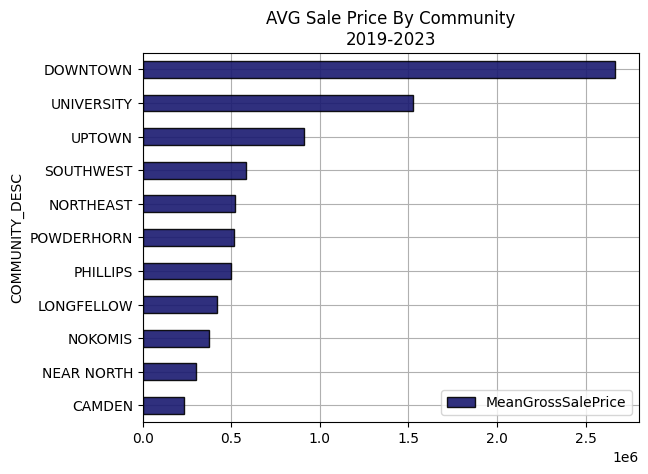

In [0]:
dfSales.\
    groupby("COMMUNITY_DESC").\
    agg(
        F.mean(dfSales.GROSS_SALE_PRICE).alias("MeanGrossSalePrice"),
        ).\
    orderBy("MeanGrossSalePrice").\
    toPandas().\
    set_index('COMMUNITY_DESC').\
    plot(kind='barh',edgecolor='black',
         grid=True,zorder=2,alpha=.9,color='midnightblue',
         title='AVG Sale Price By Community\n2019-2023')

#<br> What should I add to make this for homes?

#<br>Joining allows you to add features to your data

In [0]:
df=df.join(dfSales.select('PIN','GROSS_SALE_PRICE'),on='PIN')
df.limit(5).display()

PIN index HOUSE_NO PLAT_NO NEIGHBORHOOD COMMUNITY WARD ZONING LANDUSE PARCEL_AREA_SQFT X Y PRIMARY_PROP_TYPE LANDVALUE BLDGVALUE TOTALVALUE NUM_BLDGS BUILDINGUSE YEARBUILT BELOWGROUNDAREA ABOVEGROUNDAREA TOTAL_UNITS GROSS_SALE_PRICE 0102824110124 6 2800 19890 LONGFELLOW LONGFELLOW 2.0 CM3 MULTI-FAMILY APARTMENT 45901.0 539386.9751 156970.4318 APARTMENT 688500 14484500 15173000 1 APARTMENT 6+ UNIT 1978.0 13576 95032 120.0 1.35E7 0102824110127 9 3029 18430 LONGFELLOW LONGFELLOW 2.0 UN2 1 UNIT RESIDENTIAL - SINGLE FAMILY HOUSE 12534.0 539819.4919 156947.3083 RESIDENTIAL 125000 448000 573000 1 SINGLE FAMILY HOUSE 1991.0 1883 1931 1.0 475000.0 0102824120001 13 2716 18430 LONGFELLOW LONGFELLOW 2.0 CM3 RETAIL 5642.0 539037.7651 156894.1264 COMMERCIAL 90300 589700 680000 1 SMALL RETAIL STORE 1932.0 4830 4830 0.0 960000.0 0102824120009 14 3140 18590 LONGFELLOW LONGFELLOW 9.0 RM1 MULTI-FAMILY APARTMENT 9000.0 539045.9576 156241.7 APARTMENT 135000 823000 958000 1 APARTMENT 6+ UNIT 1962.0 1512 3024 11.0 4900000.0 0102824120010 15 3146 18590 LONGFELLOW LONGFELLOW 9.0 RM1 MULTI-FAMILY APARTMENT 12600.0 539079.726 156178.4142 APARTMENT 189000 1509000 1698000 1 APARTMENT 6+ UNIT 1961.0 3978 7956 null 4900000.0

In [0]:
CommunityGrossSale=dfSales.groupBy(['COMMUNITY_DESC']).agg(F.avg('GROSS_SALE_PRICE').alias('MeanGrossSale')).show()

+--------------+------------------+
|COMMUNITY_DESC|     MeanGrossSale|
+--------------+------------------+
|      PHILLIPS|498549.58856088563|
|       NOKOMIS| 376593.6902242912|
|     NORTHEAST| 522913.6867952894|
|      DOWNTOWN|2666313.8313542763|
|     SOUTHWEST| 580952.2769062386|
|    UNIVERSITY|1527616.3026719228|
|    LONGFELLOW| 420222.8275862069|
|        UPTOWN| 913326.6995649809|
|    NEAR NORTH| 298593.9736925515|
|    POWDERHORN|513294.62964563526|
|        CAMDEN| 233556.4643256542|
+--------------+------------------+



In [0]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

windowSpec = Window.partitionBy(['COMMUNITY','BUILDINGUSE']).orderBy(F.desc('GROSS_SALE_PRICE'))
df = df.withColumn('SaleRank', F.row_number().over(windowSpec))
display(df.filter('SaleRank==1'))

PIN index HOUSE_NO PLAT_NO NEIGHBORHOOD COMMUNITY WARD ZONING LANDUSE PARCEL_AREA_SQFT X Y PRIMARY_PROP_TYPE LANDVALUE BLDGVALUE TOTALVALUE NUM_BLDGS BUILDINGUSE YEARBUILT BELOWGROUNDAREA ABOVEGROUNDAREA TOTAL_UNITS GROSS_SALE_PRICE SaleRank 1111821130136 45792 5060 12440 SHINGLE CREEK CAMDEN 4.0 UN1 VACANT 12979.0 519678.6111 193452.3857 VACANT LAND - COMMERCIAL 0 0 0 0 null null 0 0 0.0 8650000.0 1 1211821420131 54421 4746 13450 LIND-BOHANON CAMDEN 4.0 UN3 MULTI-FAMILY APARTMENT 14245.0 524851.1886 191366.0015 APARTMENT 114000 647000 761000 1 APARTMENT 4 OR 5 UNIT 2001.0 0 6078 4.0 760000.0 1 0902924220226 33855 3520 12630 FOLWELL CAMDEN 4.0 RM1 MIXED OFFICE,RETAIL,RESIDENTIAL, ETC 11147.0 519507.1968 183210.6969 APARTMENT 89200 870800 960000 1 APARTMENT 6+ UNIT 1949.0 3276 7737 11.0 2940000.0 1 0402924140224 16044 4153 12340 WEBBER-CAMDEN CAMDEN 4.0 UN1 MULTI-FAMILY APARTMENT 9153.0 524201.1695 187430.1395 APARTMENT 73200 436800 510000 1 APARTMENT CONVERTED 1900.0 171 5424 6.0 599900.0 1 0802924130178 30956 2618 12350 CLEVELAND CAMDEN 4.0 CM1 OFFICE STRUCTURE 10222.0 517870.4378 181080.7966 COMMERCIAL 71600 308400 380000 1 CENTER NEIGH/COMM. 1974.0 0 2339 0.0 110000.0 1 0502924130092 19299 4050 12520 VICTORY CAMDEN 4.0 UN1 INSTITUTIONS:SCHL,COLLEGE,CHURCH OR HOSPITAL 36768.0 517881.79 186830.1855 COMMERCIAL 0 0 0 1 CHURCH 1900.0 18400 18400 0.0 1175000.0 1 1211821430057 54970 4601 12470 LIND-BOHANON CAMDEN 4.0 CM2 MIXED OFFICE,RETAIL,RESIDENTIAL, ETC 11587.0 524678.0825 190298.635 COMMERCIAL 81100 501900 583000 1 COM CONV W 1-3 UNIT RES 1912.0 2535 4253 1.0 1014000.0 1 0802924110002 30048 3449 12700 CLEVELAND CAMDEN 4.0 CM1 MIXED OFFICE,RETAIL,RESIDENTIAL, ETC 5423.0 519318.7547 182877.1327 COMMERCIAL 46000 309000 355000 1 COM ORIG W 1-3 UNIT RES 1917.0 1140 2933 1.0 485000.0 1 0402924120176 15715 4208 14120 WEBBER-CAMDEN CAMDEN 4.0 CM2 MIXED OFFICE,RETAIL,RESIDENTIAL, ETC 6400.0 522735.8437 187827.5297 COMMERCIAL 21400 210600 232000 2 COM USE W SF MODEL 1920.0 1212 1490 1.0 175000.0 1 0902924130216 33252 3232 2993 FOLWELL CAMDEN 4.0 RM1 1 UNIT RESIDENTIAL - CONDOMINIUM 97622.0 522793.715 181444.73 CONDOMINIUM 2000 75000 77000 1 CONDOMINIUM 1985.0 0 1073 1.0 27936.0 1 1311821120019 57070 4400 1571 CAMDEN INDUSTRIAL AREA CAMDEN 4.0 CM2 OFFICE STRUCTURE 23180.0 524804.7185 189167.6227 COMMERCIAL 139100 260900 400000 1 CONVENTION CENTER 1892.0 2289 5729 0.0 1825000.0 1 0502924440114 20753 3729 14070 CLEVELAND CAMDEN 4.0 RM1 2 UNIT RESIDENTIAL - DUPLEX 5033.0 519302.6983 184624.46 2 UNIT RESIDENTIAL 30000 257000 287000 1 DUPLEX 1931.0 1461 1802 2.0 781000.0 1 0402924140231 16067 4111 14120 WEBBER-CAMDEN CAMDEN 4.0 UN1 3 UNIT RESIDENTIAL - DUPLEX AND ADU 9588.0 523544.3266 187122.5236 3 UNIT RESIDENTIAL 31000 706000 737000 1 DUPLEX W/ADU 2020.0 1144 3432 3.0 24000.0 1 1411821120043 62603 2124 12460 VICTORY CAMDEN 4.0 CM2 BAR,RESTAURANT,CLUB,ENTERTAINMENT, ETC 3051.0 519473.5545 189194.3228 COMMERCIAL 21400 344600 366000 1 FOOD & MEAT PROCESS 1956.0 0 1888 0.0 250000.0 1 1211821430011 54424 4659 12470 LIND-BOHANON CAMDEN 4.0 UN3 GROUP RESIDENCE 18075.0 524711.4151 190815.1357 APARTMENT 126500 785500 912000 1 GROUP HOME 1958.0 1782 8610 17.0 620000.0 1 0302924230031 12201 4026 12229 CAMDEN INDUSTRIAL AREA CAMDEN 4.0 CM2 IND WAREHOUSE, FACTORY OR WORKSHOP 61405.0 525551.919 186476.6611 INDUSTRIAL 307000 2813000 3120000 1 MANUFACTURING 1946.0 0 32214 0.0 2550000.0 1 0302924320147 12589 3805 12270 WEBBER-CAMDEN CAMDEN 4.0 CM2 OFFICE STRUCTURE 68848.0 525806.7214 185126.9901 COMMERCIAL 534200 2165800 2700000 1 OFFICE 1991.0 0 15051 0.0 2275000.0 1 0402924130177 15611 4141 14120 WEBBER-CAMDEN CAMDEN 4.0 CM2 1 UNIT RESIDENTIAL - ZERO LOT LINE 3197.0 522553.1723 187515.1295 RES - ZERO LOT LINE 10000 250000 260000 1 RES ZERO LOT LINE 2005.0 788 1576 1.0 260000.0 1 0802924110082 30293 3501 13950 CLEVELAND CAMDEN 4.0 CM1 RETAIL 7744.0 519315.3462 183032.9525 COMMERCIAL 54200 235800 290000 1 RETAIL & MULTI-TENANT 1922.0 3310 3261 0.0 325000.

#<br>What seasonal pattern are we seeing here?
#<br>

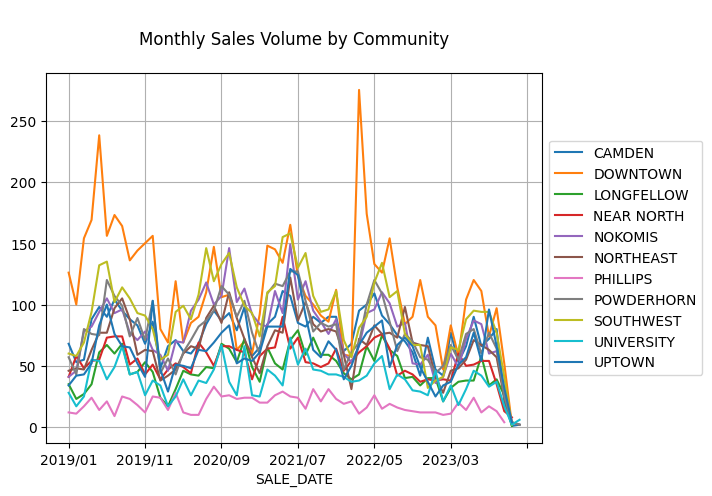

In [0]:
dfSales.\
    withColumn('SALE_DATE', F.substring('SALE_DATE', 0, 10)).\
    withColumn('SALE_DATE', F.to_date('SALE_DATE', 'yyyy/MM/dd')).\
    withColumn('SALE_DATE', F.date_format('SALE_DATE', 'yyyy/MM')).\
    withColumn('Dummy', F.lit(1)).\
    groupBy(['SALE_DATE']).\
    pivot('COMMUNITY_DESC').sum('Dummy').\
    orderBy('SALE_DATE').\
    toPandas().\
    set_index('SALE_DATE').\
    plot(grid=True,
         title='\nMonthly Sales Volume by Community\n').legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

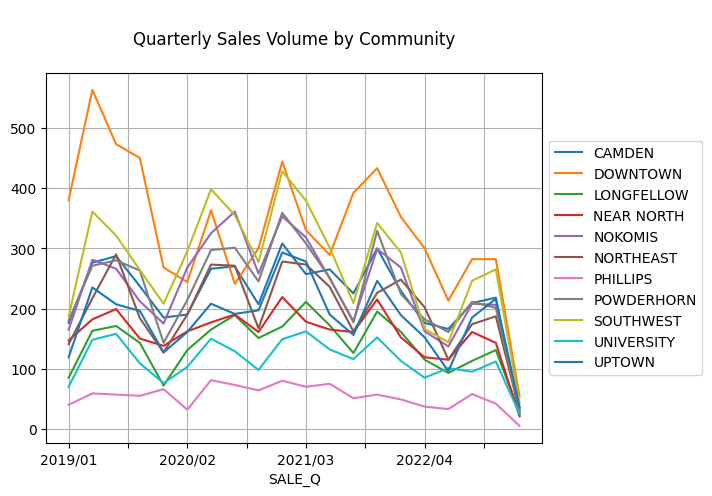

In [0]:
dfSales.\
    withColumn('SALE_DATE', F.substring('SALE_DATE', 0, 10)).\
    withColumn('SALE_DATE', F.to_date('SALE_DATE', 'yyyy/MM/dd')).\
    withColumn('SALE_Q', F.date_format('SALE_DATE', 'yyyy/QQ')).\
    withColumn('SALE_DATE', F.date_format('SALE_DATE', 'yyyy/MM')).\
    withColumn('Dummy', F.lit(1)).\
    groupBy(['SALE_Q']).\
    pivot('COMMUNITY_DESC').sum('Dummy').\
    orderBy('SALE_Q').\
    toPandas().\
    set_index('SALE_Q').\
    plot(grid=True,
         title='\nQuarterly Sales Volume by Community\n').legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

#<br>Who says you can't time the market?

<Axes: title={'center': 'Quarterly Median Sale Price of Residential Properties'}, xlabel='SALE_Q'>

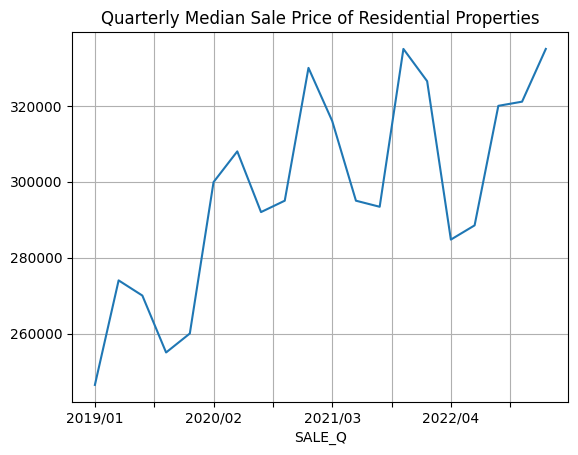

In [0]:
dfSales.\
    filter('PROPTYPE_DESC=="RESIDENTIAL"').\
    withColumn('SALE_DATE', F.substring('SALE_DATE', 0, 10)).\
    withColumn('SALE_DATE', F.to_date('SALE_DATE', 'yyyy/MM/dd')).\
    withColumn('SALE_Q', F.date_format('SALE_DATE', 'yyyy/QQ')).\
    withColumn('SALE_DATE', F.date_format('SALE_DATE', 'yyyy/MM')).\
    withColumn('Dummy', F.lit(1)).\
    groupBy(['SALE_Q']).\
    agg(F.median('GROSS_SALE_PRICE')).\
    orderBy('SALE_Q').\
    toPandas().set_index('SALE_Q').plot(grid=True,title='Quarterly Median Sale Price of Residential Properties',legend=False)

###<br>Can anyone make the same chart, but with the mean percent down column?

<Axes: title={'center': 'Quarterly Median Sale Price of Residential Properties'}, xlabel='SALE_Q'>

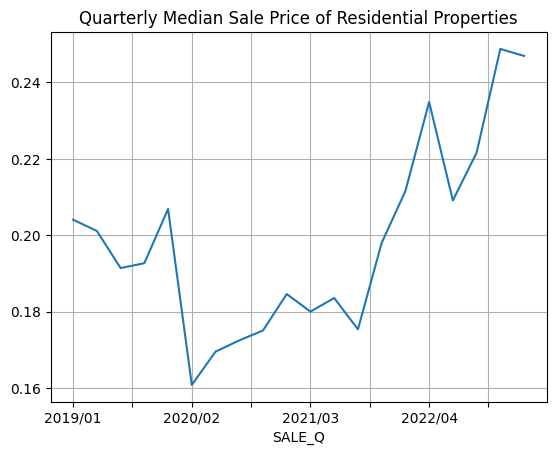

In [0]:
pd.options.plotting.backend = "matplotlib"
dfSales.\
    filter('PROPTYPE_DESC=="RESIDENTIAL"').\
    withColumn('SALE_DATE', F.substring('SALE_DATE', 0, 10)).\
    withColumn('SALE_DATE', F.to_date('SALE_DATE', 'yyyy/MM/dd')).\
    withColumn('SALE_Q', F.date_format('SALE_DATE', 'yyyy/QQ')).\
    withColumn('SALE_DATE', F.date_format('SALE_DATE', 'yyyy/MM')).\
    withColumn('Dummy', F.lit(1)).\
    groupBy(['SALE_Q']).\
    agg(F.mean('PercentDown')).\
    orderBy('SALE_Q').\
    toPandas().set_index('SALE_Q').plot(grid=True,title='Quarterly Median Sale Price of Residential Properties',legend=False)

# Pretty Simple To Write To A Table 

In [0]:
dfSales.\
    filter('PROPTYPE_DESC=="RESIDENTIAL"').\
    filter('COMMUNITY_DESC!="DOWNTOWN"').\
    withColumn('SALE_DATE', F.substring('SALE_DATE', 0, 10)).\
    withColumn('SALE_DATE', F.to_date('SALE_DATE', 'yyyy/MM/dd')).\
    withColumn('SALE_DATE', F.date_format('SALE_DATE', 'yyyy/MM')).\
    groupBy(['SALE_DATE','COMMUNITY_DESC']).\
    agg(F.median('GROSS_SALE_PRICE').alias('MedianSalePrice')).\
    orderBy('SALE_DATE').\
    write.format('delta').mode('overwrite').saveAsTable('workspace.bronze.MedianSalePriceTS')

#<br>Changing the backend will change the plotting engine

In [0]:
pd.options.plotting.backend = "plotly"
dfSales.\
    filter('GROSS_SALE_PRICE>0').\
    filter('PROPTYPE_DESC=="RESIDENTIAL"').\
    withColumn('PercentDown',dfSales['DOWNPAYMENT']/dfSales['GROSS_SALE_PRICE']).\
    withColumn('Dummy',F.lit(1)).\
    groupBy('NBHD_DESC').\
    agg(
        F.mean('PercentDown').alias('MeanPercentDown'),
        F.sum('Dummy').alias('Count'),
        F.mean('GROSS_SALE_PRICE').alias('MeanPrice')
        ).\
    filter('Count>20').\
    select('NBHD_DESC','MeanPercentDown','MeanPrice').\
    withColumn('MeanPercentDown',F.col('MeanPercentDown')*100).\
    toPandas().\
    plot.scatter(
        x='MeanPrice',
        y='MeanPercentDown',
        s=40,
        title='Mean Percent Down VS Neighborhood Mean Sale Price',
        hover_name='NBHD_DESC',
        trendline="ols"
    ).\
    update_yaxes(tickprefix="%").\
    update_xaxes(tickprefix="$")

###<br> What if we did the same chart but with neighborhood sale count?

# <br> What should we check out in df?

In [0]:
df.display()

PIN index HOUSE_NO PLAT_NO NEIGHBORHOOD COMMUNITY WARD ZONING LANDUSE PARCEL_AREA_SQFT X Y PRIMARY_PROP_TYPE LANDVALUE BLDGVALUE TOTALVALUE NUM_BLDGS BUILDINGUSE YEARBUILT BELOWGROUNDAREA ABOVEGROUNDAREA TOTAL_UNITS GROSS_SALE_PRICE 0102824110124 6 2800 19890 LONGFELLOW LONGFELLOW 2.0 CM3 MULTI-FAMILY APARTMENT 45901.0 539386.9751 156970.4318 APARTMENT 688500 14484500 15173000 1 APARTMENT 6+ UNIT 1978.0 13576 95032 120.0 1.35E7 0102824110127 9 3029 18430 LONGFELLOW LONGFELLOW 2.0 UN2 1 UNIT RESIDENTIAL - SINGLE FAMILY HOUSE 12534.0 539819.4919 156947.3083 RESIDENTIAL 125000 448000 573000 1 SINGLE FAMILY HOUSE 1991.0 1883 1931 1.0 475000.0 0102824120001 13 2716 18430 LONGFELLOW LONGFELLOW 2.0 CM3 RETAIL 5642.0 539037.7651 156894.1264 COMMERCIAL 90300 589700 680000 1 SMALL RETAIL STORE 1932.0 4830 4830 0.0 960000.0 0102824120009 14 3140 18590 LONGFELLOW LONGFELLOW 9.0 RM1 MULTI-FAMILY APARTMENT 9000.0 539045.9576 156241.7 APARTMENT 135000 823000 958000 1 APARTMENT 6+ UNIT 1962.0 1512 3024 11.0 4900000.0 0102824120010 15 3146 18590 LONGFELLOW LONGFELLOW 9.0 RM1 MULTI-FAMILY APARTMENT 12600.0 539079.726 156178.4142 APARTMENT 189000 1509000 1698000 1 APARTMENT 6+ UNIT 1961.0 3978 7956 null 4900000.0 0102824120051 34 3112 19540 LONGFELLOW LONGFELLOW 9.0 RM1 MULTI-FAMILY APARTMENT 15000.0 538892.5683 156534.1033 APARTMENT 225000 1382000 1607000 1 APARTMENT 6+ UNIT 1965.0 4346 8692 18.0 1863000.0 0102824120052 35 3120 19540 LONGFELLOW LONGFELLOW 9.0 RM1 1 UNIT RESIDENTIAL - SINGLE FAMILY HOUSE 3826.0 538921.7665 156478.8819 RESIDENTIAL 54000 111000 165000 1 SINGLE FAMILY HOUSE 1906.0 180 720 1.0 190000.0 0102824120058 38 3136 19540 LONGFELLOW LONGFELLOW 9.0 RM1 MULTI-FAMILY APARTMENT 7501.0 539020.1805 156290.4562 APARTMENT 68100 2581900 2650000 1 APARTMENT 6+ UNIT 2020.0 0 12171 18.0 180000.0 0102824120080 42 3147 19540 LONGFELLOW LONGFELLOW 9.0 PR2 IND WAREHOUSE, FACTORY OR WORKSHOP 7650.0 538218.8404 156280.2287 INDUSTRIAL 107100 33000 140100 1 WORKSHOP 1917.0 700 2660 0.0 300000.0 0102824120081 43 3161 19540 LONGFELLOW LONGFELLOW 9.0 PR2 IND WAREHOUSE, FACTORY OR WORKSHOP 27250.0 538275.333 156179.476 INDUSTRIAL 381500 1058500 1440000 1 MANUFACTURING 1920.0 0 25250 0.0 550000.0 0102824120093 45 3017 19720 LONGFELLOW LONGFELLOW 2.0 CM3 VACANT 7850.0 538997.5949 157113.1926 VACANT LAND - COMMERCIAL 0 0 0 0 null null 0 0 0.0 175000.0 0102824120096 48 2701 19720 LONGFELLOW LONGFELLOW 2.0 CM4 VACANT 14213.0 538995.8608 157279.8864 VACANT LAND - COMMERCIAL 405800 0 405800 0 null null 0 0 0.0 900000.0 0102824130058 56 3327 20330 CORCORAN POWDERHORN 9.0 UN2 1 UNIT RESIDENTIAL - SINGLE FAMILY HOUSE 6843.0 537943.3306 155024.5283 RESIDENTIAL 117000 58000 175000 1 SINGLE FAMILY HOUSE 1912.0 528 840 1.0 158000.0 0102824130059 57 3331 20330 CORCORAN POWDERHORN 9.0 UN2 1 UNIT RESIDENTIAL - SINGLE FAMILY HOUSE 6843.0 537943.2097 154973.4488 RESIDENTIAL 117000 104000 221000 1 SINGLE FAMILY HOUSE 1912.0 748 783 1.0 219900.0 0102824130062 60 3338 20330 CORCORAN POWDERHORN 9.0 UN2 1 UNIT RESIDENTIAL - SINGLE FAMILY HOUSE 6263.0 538088.4379 154873.6456 RESIDENTIAL 112000 253000 365000 1 SINGLE FAMILY HOUSE 1918.0 890 1358 1.0 400000.0 0102824130063 61 3334 20330 CORCORAN POWDERHORN 9.0 UN2 1 UNIT RESIDENTIAL - SINGLE FAMILY HOUSE 6348.0 538088.3323 154922.8345 RESIDENTIAL 113000 206000 319000 1 SINGLE FAMILY HOUSE 1916.0 624 996 1.0 312000.0 0102824130064 62 3330 20330 CORCORAN POWDERHORN 9.0 UN2 1 UNIT RESIDENTIAL - SINGLE FAMILY HOUSE 6348.0 538088.5085 154973.5427 RESIDENTIAL 113000 261000 374000 1 SINGLE FAMILY HOUSE 1914.0 816 1431 1.0 341000.0 0102824130080 72 2717 3382 LONGFELLOW LONGFELLOW 9.0 PR2 IND WAREHOUSE, FACTORY OR WORKSHOP 46698.0 539003.7444 155226.5242 INDUSTRIAL 653800 1821200 2475000 1 WAREHOUSE 1986.0 0 20040 0.0 2425000.0 0102824130098 82 3203 20330 CORCORAN POWDERHORN 9.0 UN2 1 UNIT RESIDENTIAL - SINGLE FAMILY HOUSE 7597.0 537944.1858 155942.0074 RESIDENTIAL 121000 237000 358000 1 SINGLE FAMILY HOUSE 1994.0 1080 1100 1.0 20500

# More you ought to look into 
- Joins
- Window functions
- lazy evaluation 

# Data Bricks Free Version Advice
- Use this a learning environment 
- Auth is buggy, be ready ready to lose all your work
- Save often